# glasma configuration

In [1]:
N = 128
L = 6.0

# define hbar * c in units of GeV * fm
hbarc = 0.197326 

a = L / N
E0 = 1 / a * hbarc

mu = 0.5
m = 0.2
uv = 20.0
ns = 20

g = 2.0
DTS = 8
dt = 1.0 / DTS

In [2]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
from curraun.energy import Energy
import curraun.initial as initial
from curraun import wong
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle, datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})

Using Numba
Using SU(2)
Using double precision
Using double precision
Using double precision


# glasma initialization

In [3]:
s = core.Simulation(N, dt, g)
va = mv.wilson(s, mu=mu / E0, m=m / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=m / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

# wong initialization

In [4]:
n_particles = 500
wong_solver = wong.WongSolver(s, n_particles)

In [5]:
# add particles at center with random pT
pT = 0.0005 / E0
q0_scale = np.sqrt(3./2.)

for i in range(n_particles):
    x0 = np.random.rand(3) * s.n
    
    angle = 2*np.pi*np.random.rand(1)
    p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
    mass = 1.270 / E0 # charm quark mass
    #mass = 0.001 / E0 # almost massless
    
    q0 = np.random.normal(size=3)
    q0 = q0_scale * q0 / np.linalg.norm(q0)
    
    wong_solver.add_particle(x0, p0, q0, mass)

# glasma + wong evolution

In [6]:
tau_max = 2.0
t_max = int(tau_max / a * DTS)

# position, momentum and charge history
xs = np.zeros((t_max, n_particles, 3))
ps = np.zeros((t_max, n_particles, 4))
qs = np.zeros((t_max, n_particles, 4))

for t in range(t_max):
    core.evolve_leapfrog(s)
    wong_solver.evolve()
    xs[t] = wong_solver.x0.copy()
    ps[t] = wong_solver.p.copy()
    qs[t] = wong_solver.q.copy()

# plotting trajectories

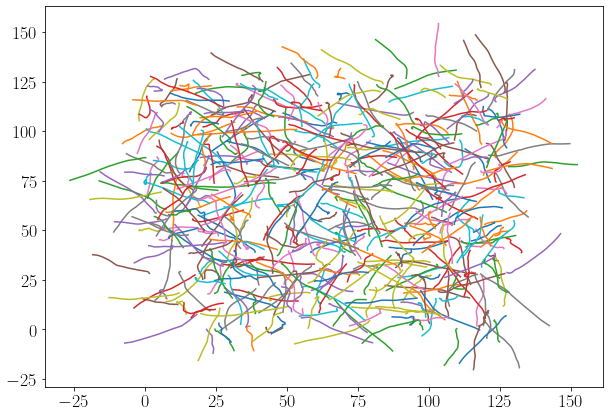

In [7]:
for i in range(n_particles):
    plt.plot(xs[:, i, 0], xs[:, i, 1])

# quadratic casimir check

(0.6123724356958107, 0.6123724356957786)

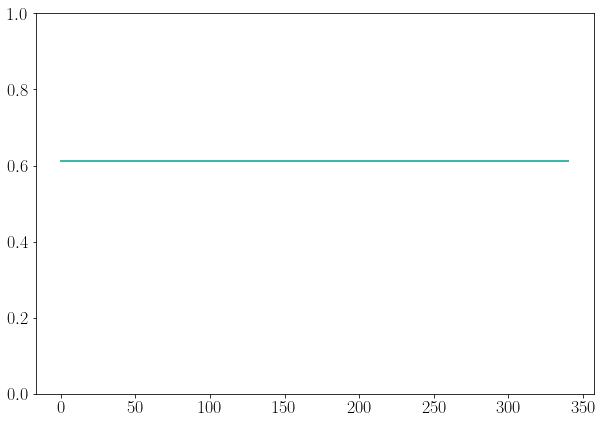

In [8]:
for i in range(n_particles):
    plt.plot(range(t_max), np.linalg.norm(qs[:, i], axis=1))
plt.ylim([0, 1])

np.max(np.linalg.norm(qs, axis=-1)), np.min(np.linalg.norm(qs, axis=-1))